# Inference Tutorial

In this tutorial we will cover:
- [Requirements](#Requirements)
- [Loading a SWAG model](#Loading-a-SWAG-model)
- [Running Inference](#Running-Inference)
    - [Dog Example](#Image-prediction-example-1)
    - [Panda Example](#Image-prediction-example-2)
    - [Space Shuttle Example](#Image-prediction-example-3)

## Requirements

You need to have PyTorch and torchvision installed. Follow the [Requirements](https://github.com/facebookresearch/SWAG#requirements) section in the README for more details.

For this tutorial we will also need matplotlib which can be installed via pip -

In [1]:
import sys


!{sys.executable} -m pip install matplotlib

Looking in indexes: https://pypi.org/simple, http://webservice


## Loading a SWAG model

Our models are available via [torch.hub](https://pytorch.org/docs/stable/hub.html). 
We provide (1) pre-trained trunks, which can be for transfer learning (2) ImageNet 1K (IN-1K) fine-tuned models. 
Find the model you are looking for and its torch hub name in the [Model Zoo](https://github.com/facebookresearch/SWAG#model-zoo) section of the README.

Let's assume we want to run inference on our best model, a ViT H/14, fine-tuned on IN-1K. The corresponding torch hub name is `vit_h14_in1k`. We also make note of the expected resolution, which is `518 x 518`.

In [2]:
import torch


model = torch.hub.load("facebookresearch/swag", model="vit_h14_in1k")

# we also convert the model to eval mode
model.eval()

resolution = 518

## Running Inference

Let's try to find out the ImageNet 1K class predictions for a few images. 

### Downloading the ImageNet 1K class mapping

First, we need to download the ImageNet 1K ID to class mappings.

In [3]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json -O in_cls_idx.json

--2022-01-19 18:30:18--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.77.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.77.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘in_cls_idx.json’

in_cls_idx.json     100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2022-01-19 18:30:18 (559 KB/s) - ‘in_cls_idx.json’ saved [35363/35363]



In [4]:
import json


with open("in_cls_idx.json", "r") as f:
    imagenet_id_to_name = {int(cls_id): name for cls_id, (label, name) in json.load(f).items()}

# let's preview the first few class names 
dict(sorted(imagenet_id_to_name.items())[: 10])

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich'}

### Image load and transformation code

Now we write some code to load, visualize, and transform an image.

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def load_image(image_path):
    return Image.open(image_path).convert("RGB")

def visualize_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

def transform_image(image, resolution):
    transform = transforms.Compose([
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.BICUBIC,
        ),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ])
    image = transform(image)
    # we also add a batch dimension to the image since that is what the model expects
    image = image[None, :]
    return image

### Class prediction code
Next, we write a few lines to print the top 5 classes predicted by our model.

In [6]:
def visualize_and_predict(model, resolution, image_path):
    image = load_image(image_path)
    visualize_image(image)
    image = transform_image(image, resolution)
    
    # we do not need to track gradients for inference
    with torch.no_grad():
        _, preds = model(image).topk(5)
    
    # convert preds to a Python list and remove the batch dimension
    preds = preds.tolist()[0]
    print([imagenet_id_to_name[cls_id] for cls_id in preds])

### Image prediction example 1

Let's try what our model predicts for our first image with a dog!

In [7]:
!wget https://github.com/pytorch/hub/raw/master/images/dog.jpg -O dog.jpg

--2022-01-19 18:30:26--  https://github.com/pytorch/hub/raw/master/images/dog.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg [following]
--2022-01-19 18:30:27--  https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 661378 (646K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 645.88K  --.-KB/s    in 0.07s   

2022-01-19 18:30:27 (9.63 MB/s) - ‘dog.jpg’ saved [661378/661378]



['Samoyed', 'keeshond', 'Pomeranian', 'Japanese_spaniel', 'white_wolf']


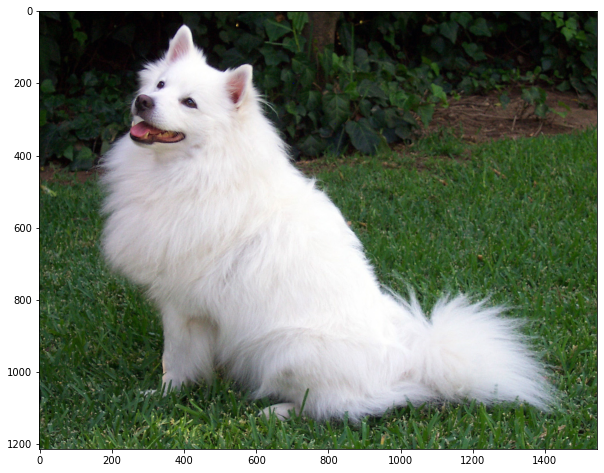

In [8]:
visualize_and_predict(model, resolution, "dog.jpg")

### Image prediction example 2

Let's try another image, this time of a Panda!

In [9]:
!wget 'https://ids.si.edu/ids/download?id=NZP-20050824-264JC.jpg' -O panda.jpg

--2022-01-19 18:30:31--  https://ids.si.edu/ids/download?id=NZP-20050824-264JC.jpg
Resolving ids.si.edu (ids.si.edu)... 160.111.252.222
Connecting to ids.si.edu (ids.si.edu)|160.111.252.222|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://smithsonian-open-access.s3-us-west-2.amazonaws.com/media/nzp/NZP-20050824-264JC.jpg [following]
--2022-01-19 18:30:32--  https://smithsonian-open-access.s3-us-west-2.amazonaws.com/media/nzp/NZP-20050824-264JC.jpg
Resolving smithsonian-open-access.s3-us-west-2.amazonaws.com (smithsonian-open-access.s3-us-west-2.amazonaws.com)... 52.218.178.41
Connecting to smithsonian-open-access.s3-us-west-2.amazonaws.com (smithsonian-open-access.s3-us-west-2.amazonaws.com)|52.218.178.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1030520 (1006K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>]   1006K  3.91MB/s    in 0.3s    

2022-01-19 18:30:32 (3.91 MB/s) - ‘pand

['giant_panda', 'lesser_panda', 'ice_bear', 'sloth_bear', 'indri']


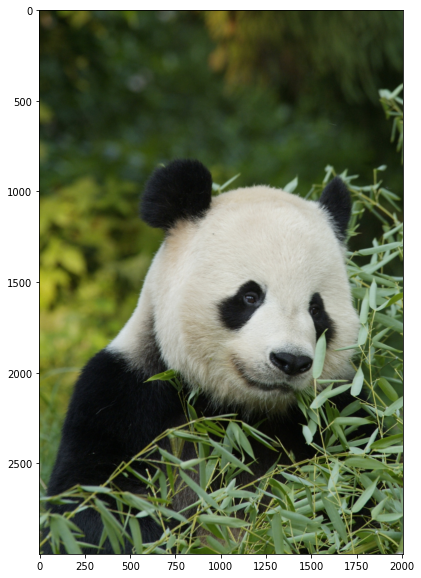

In [10]:
visualize_and_predict(model, resolution, "panda.jpg")

### Image prediction example 3

Enough with animals, let's predict an image of a space shuttle!

In [11]:
!wget 'https://ids.si.edu/ids/download?id=NASM-NASM2013-02575.jpg' -O space_shuttle.jpg

--2022-01-19 18:30:37--  https://ids.si.edu/ids/download?id=NASM-NASM2013-02575.jpg
Resolving ids.si.edu (ids.si.edu)... 160.111.252.222
Connecting to ids.si.edu (ids.si.edu)|160.111.252.222|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://smithsonian-open-access.s3-us-west-2.amazonaws.com/media/nasm/NASM-NASM2013-02575.jpg [following]
--2022-01-19 18:30:37--  https://smithsonian-open-access.s3-us-west-2.amazonaws.com/media/nasm/NASM-NASM2013-02575.jpg
Resolving smithsonian-open-access.s3-us-west-2.amazonaws.com (smithsonian-open-access.s3-us-west-2.amazonaws.com)... 52.218.224.185
Connecting to smithsonian-open-access.s3-us-west-2.amazonaws.com (smithsonian-open-access.s3-us-west-2.amazonaws.com)|52.218.224.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3069168 (2.9M) [image/jpeg]
Saving to: ‘space_shuttle.jpg’

space_shuttle.jpg   100%[===================>]   2.93M  4.55MB/s    in 0.6s    

2022-01-19 18:30:38 (4.55

['space_shuttle', 'planetarium', 'missile', 'projectile', 'warplane']


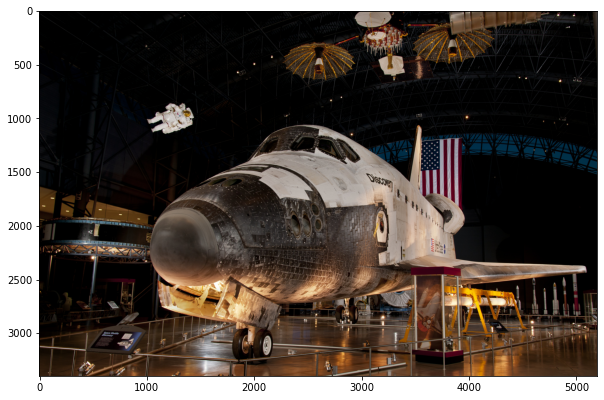

In [12]:
visualize_and_predict(model, resolution, "space_shuttle.jpg")